# Plotting Results

### Imports, Path Definitions, and Read Project Data

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Set path to images
p_images = '../reports/images/'

In [130]:
#import data from csv-file
df_zip_suitable = pd.read_csv('../data/zip_codes_suitable_neighborhoods.csv')
df_sales = pd.read_csv('../data/sales.csv')
df_zip_urban = pd.read_csv('../data/zip_codes_classification_geo.csv')
all_zip = pd.read_csv('../data/zip_codes_king_county.csv')

### Prepare Dataframes for Assessment of Selling in City Center and Buying in Oustskirts

In addition to finding suitable neighborhoods, we need to look for low-profile houses within the respective zip code areas. Low profile here means appearing average from a pedestrians view (house size, lot size, number of floors, comparability to neighboring houses). Due to the lack of time we simply go by good guesses for what characterizes an average houses. Interior characteristics are of secondary importance, but should fullfill minimum requirements (bathroom, bedroom, living space, condition). Grade and price are constrained to avoid suspicious purchases. The following features from the data set and their respective ranges are chosen to identify suitable houses:

feature | long name | range
--- | --- | ---
sqft_above | square footage of house apart from basement | 1000 - 2000
sqft_lot | footage of the lot | 5000 - 10000
sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors | 5000 - 10000
sqft_living | footage of the home | > 1000
floors | floors (levels) in house | < 3
bathrooms | # of bathrooms | > 1
bedrooms | # of bedrooms | > 1
condition | How good the condition is ( Overall ) | > 2
grade | overall grade given to the housing unit, based on King County grading system | > 6
price | price sold for | 400000 - 800000

In [131]:
df_selling

,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,price,date,sales_year,sales_month,sales_day,sales_week
10,6127600110,4.0,2.00,1520.0,6200.0,1.5,3,7,1520.0,NaN,...,47.6780,-122.269,1910.0,6200.0,640000.0,2014-05-02 00:00:00,2014,5,2,18
12,5100401414,2.0,1.00,880.0,6380.0,1.0,3,7,880.0,NaN,...,47.6924,-122.322,1340.0,6380.0,490000.0,2014-05-02 00:00:00,2014,5,2,18
19,9267200226,3.0,2.50,1770.0,1235.0,3.0,3,8,1600.0,170.0,...,47.6965,-122.342,1680.0,1203.0,436110.0,2014-05-02 00:00:00,2014,5,2,18
21,1962200037,3.0,2.25,1750.0,1572.0,2.5,3,9,1470.0,280.0,...,47.6498,-122.321,2410.0,3050.0,626000.0,2014-05-02 00:00:00,2014,5,2,18
30,1860600135,5.0,2.50,3650.0,9050.0,2.0,5,10,3370.0,280.0,...,47.6345,-122.367,2880.0,5400.0,2380000.0,2014-05-02 00:00:00,2014,5,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21582,9828700685,3.0,1.75,1540.0,8400.0,1.5,3,7,1540.0,NaN,...,47.6187,-122.295,1330.0,4800.0,900000.0,2015-05-13 00:00:00,2015,5,13,20
21583,6815100380,3.0,1.75,1900.0,4000.0,1.0,3,7,1300.0,600.0,...,47.6854,-122.331,1880.0,4000.0,855000.0,2015-05-14 00:00:00,2015,5,14,20
21591,9178601660,5.0,3.00,3320.0,5354.0,2.0,3,9,3320.0,NaN,...,47.6542,-122.331,2330.0,4040.0,1700000.0,2015-05-14 00:00:00,2015,5,14,20
21595,5101400871,2.0,1.75,1390.0,6670.0,1.0,3,6,720.0,670.0,...,47.6914,-122.308,920.0,6380.0,445500.0,2015-05-24 00:00:00,2015,5,24,21


In [132]:
# reduce dataframe to top 10% neighborhoods in city center
df_selling = df_sales[df_sales.zipcode.isin(df_zip_urban['City Center'].dropna())]
df_selling10 = df_selling[df_selling.price > df_selling.price.quantile(0.9)]

# convert date feature to type datetime
df_selling.loc[:, 'date'] = pd.to_datetime(df_selling.date)
df_selling10.loc[:, 'date'] = pd.to_datetime(df_selling10.date)

# reduce dataframe to neighborhoods in outskirts
df_buying = df_sales[df_sales.zipcode.isin(df_zip_suitable.zipcode)]

# convert date feature to type datetime
df_buying.loc[:, 'date'] = pd.to_datetime(df_buying.date)

avg_house_dict = {}
avg_house_dict['sqft_above'] = [1000, 2000]
avg_house_dict['sqft_lot'] = [5000, 10000]
avg_house_dict['sqft_lot15'] = [5000, 10000]
avg_house_dict['sqft_living'] = [1000, 99999999]
avg_house_dict['floors'] = [0, 3]
avg_house_dict['bathrooms'] = [1, 100]
avg_house_dict['bedrooms'] = [1, 100]
avg_house_dict['condition'] = [3, 100]
avg_house_dict['grade'] = [7, 10]
avg_house_dict['price'] = [400000, 800000]

df_buying_avg = df_buying.copy()
print('Number of houses sold in suitable neighborhoods:', df_buying_avg.house_id.count())
for i in avg_house_dict:
    df_buying_avg = df_buying_avg[df_buying_avg[i] > avg_house_dict[i][0]]
    df_buying_avg = df_buying_avg[df_buying_avg[i] < avg_house_dict[i][1]]
print('Number of suitable houses within suitable neighborhoods', df_buying_avg.house_id.count())

Number of houses sold in suitable neighborhoods: 4654
Number of suitable houses within suitable neighborhoods 62


## Job 1 - When to Sell Top Assets in City Center?

#### Sales Overall in City Center (Last 12 Month)

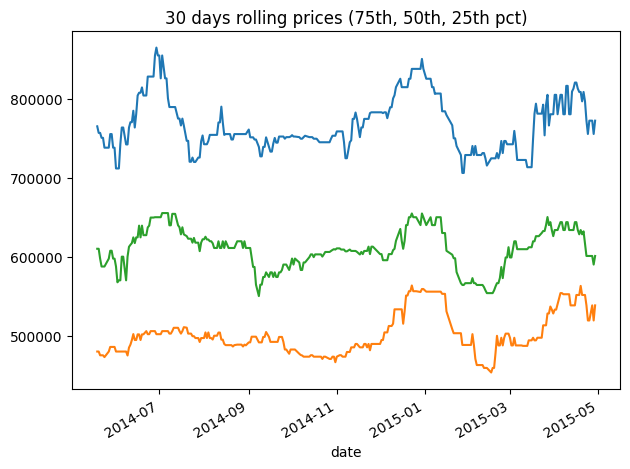

In [133]:
# plot prices for 30 days rolling mean
df_group_14days = df_selling.groupby(df_selling.date).quantile(0.75).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_selling.groupby(df_selling.date).quantile(0.25).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_selling.groupby(df_selling.date).quantile(0.5).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
plt.title('30 days rolling prices (75th, 50th, 25th pct)')
plt.tight_layout()
plt.savefig(p_images+"price_city_30days_roll_mean.png",dpi=300)
plt.show()

#### Top 10% Sales in City Center (Last 12 Month)

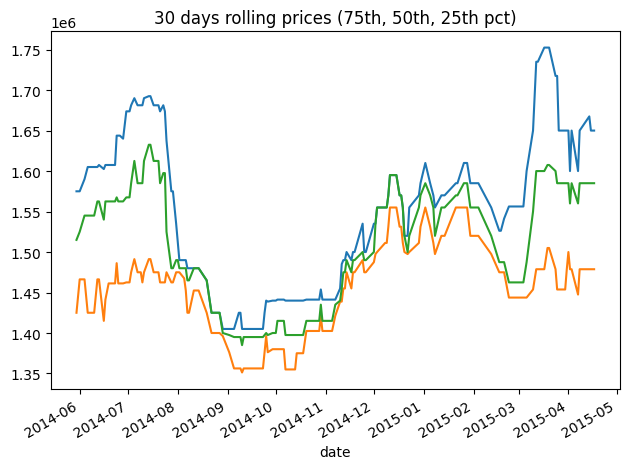

In [134]:
# plot prices for 30 days rolling mean
df_group_14days = df_selling10.groupby(df_selling10.date).quantile(0.75).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_selling10.groupby(df_selling10.date).quantile(0.25).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_selling10.groupby(df_selling10.date).quantile(0.5).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
plt.title('30 days rolling prices (75th, 50th, 25th pct)')
plt.tight_layout()
plt.savefig(p_images+"price_city_top10pct_30days_roll_mean.png",dpi=300)
plt.show()

## Job 2 - What Prices to Expect for Low-Profile Houses in Ideal Locations?

#### Sales Overall in Suitable Neighborhoods (Last 12 Month)

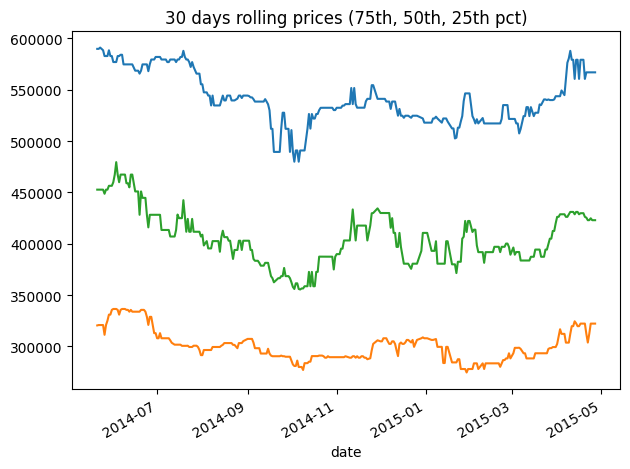

In [135]:
# plot prices for 30 days rolling mean
df_group_14days = df_buying.groupby(df_buying.date).quantile(0.75).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_buying.groupby(df_buying.date).quantile(0.25).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_buying.groupby(df_buying.date).quantile(0.5).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
plt.title('30 days rolling prices (75th, 50th, 25th pct)')
plt.tight_layout()
plt.savefig(p_images+"price_suit_neighb_30days_roll_mean.png",dpi=300)
plt.show()

#### Sales of Suitable Houses in Suitable Neighborhoods (Last 12 Month)

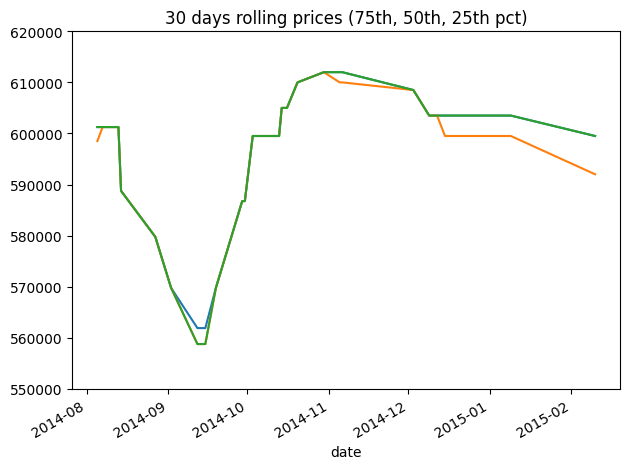

In [136]:
# plot prices for 30 days rolling mean
df_group_14days = df_buying_avg.groupby(df_buying_avg.date).quantile(0.75).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_buying_avg.groupby(df_buying_avg.date).quantile(0.25).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
df_group_14days = df_buying_avg.groupby(df_buying_avg.date).quantile(0.5).rolling(30, center=True).quantile(0.5)
df_group_14days.price.plot()
plt.title('30 days rolling prices (75th, 50th, 25th pct)')
plt.ylim([550000,620000])
plt.tight_layout()
plt.savefig(p_images+"price_suit_houses_suit_neighb_30days_roll_mean.png",dpi=300)
plt.show()

#### Highlight Remaining Suitable Neighborhoods and Zip Code where most Suitable Houses were Sold (Last 12 Month)

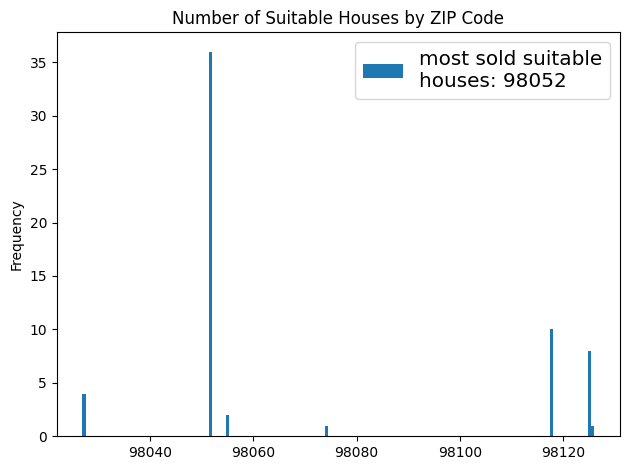

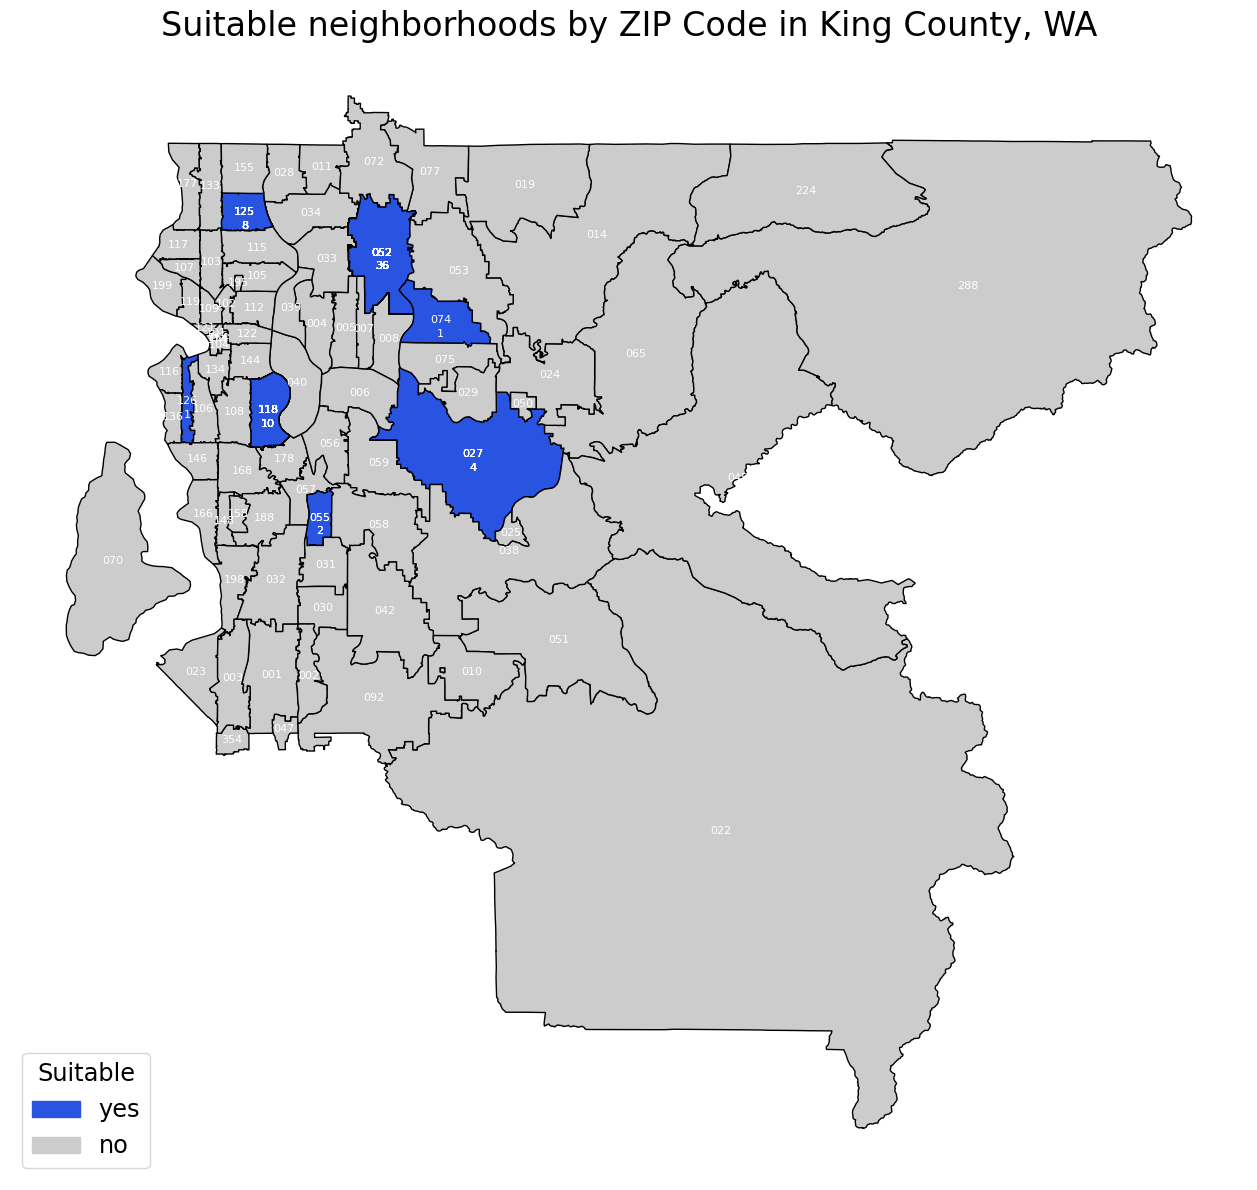

In [137]:
# check histogram of remaining zipcodes
zip_count = df_buying_avg.groupby('zipcode')['zipcode'].count()
zip_max_idx = zip_count[zip_count == zip_count.max()].index.values[0]
zip_count.index = zip_count.index.map(lambda x: str(x)[-3:])
df_buying_avg['zipcode'].plot(kind='hist', title=i, bins=150,
                            label=f'most sold suitable\nhouses: {zip_max_idx}')
plt.legend(fontsize='x-large')
plt.title('Number of Suitable Houses by ZIP Code')
plt.tight_layout()
plt.savefig(p_images+"suit_houses_no_per_zip.png",dpi=300)
plt.show()

# prepare dataframe for plotting remaining zip codes
# Load ZIP code boundaries for King County
shapefile_path = '../data/zip_codes_wa/zip_codes_wa.shp'   # path to map file

zip_shapes = gpd.read_file(shapefile_path)
zip_shapes = zip_shapes[zip_shapes['ZCTA5CE20'].astype(int).isin(all_zip.zipcode.values)]
zip_shapes = zip_shapes.rename(columns={'ZCTA5CE20': 'zipcode'})
zip_shapes['zipcode'] = zip_shapes['zipcode'].astype(int)
zip_shapes['zip3'] = zip_shapes['zipcode'].astype(str)
zip_shapes['zip3'] = zip_shapes['zip3'].apply(lambda x: x[-3:])

# swap lat and lon
cols = list(zip_shapes.columns)
a, b = cols.index('INTPTLAT20'), cols.index('INTPTLON20')
cols[b], cols[a] = cols[a], cols[b]
zip_shapes = zip_shapes[cols]

# Merge category data with geospatial data
merged = zip_shapes.merge(df_buying_avg, on='zipcode', how='left')

merged['suitable'] = 1
merged.loc[merged['sales_year'].isna(), 'suitable'] = np.nan

# Assign fill colors (including gray for NaN)
colors = {
    1: "#2954e1",        # blue
    np.nan: '#cccccc'
}
d_legend = {1: 'yes', np.nan: 'no'}

# Plot the map
fig, ax = plt.subplots(figsize=(13, 12))
merged.plot(ax=ax, cmap=None, color=merged['suitable'].map(colors),
            legend=True, edgecolor='black')

# Add the zip code suffixes as labels
for idx, row in merged.iterrows():
    if row['geometry'].is_empty:
        continue
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['zip3'],
            fontsize=8, ha='center', va='center', color='white')
    if row['zip3'] in zip_count.index:
        ax.text(centroid.x, centroid.y-0.012,
                zip_count[zip_count.index == row['zip3']].values[0],
                fontsize=8, ha='center', va='center', color='white')
    
plt.title('Suitable neighborhoods by ZIP Code in King County, WA', fontsize=24)
plt.axis('off')

# Add custom legend
legend_handles = [mpatches.Patch(color=color, label=label) for (
    (_, color), (_, label)) in zip(colors.items(), d_legend.items()
)]
ax.legend(handles=legend_handles, title='Suitable', loc='lower left',
          fontsize='xx-large', title_fontsize='xx-large')
plt.tight_layout()
plt.savefig(p_images+"suit_neighb_geo_distr.png",dpi=300)
plt.show()

# Store result in csv file
df_suitable = merged.zipcode[merged.suitable == 1]
df_suitable
df_suitable.to_csv('../data/suitable_houses_in_zip.csv', index=False)